# Project

You can find a link to the website here: https://www.student.dtu.dk/~s164397/home/

# Motivation

## Data

The dataset I have decided to use is a mix between two separate wikis on the Pokémon games. The first wiki is the pokemon fandom wiki [[1]](https://pokemon.fandom.com/wiki/List_of_Pok%C3%A9mon). From this wiki I have extracted both the full list of Pokémon from generations 1-3, their **TYPE**s, and their entries in the Pokédex for each game. The second wiki is the Bulbapedia page [[2]](https://bulbapedia.bulbagarden.net/wiki/List_of_moves). From this wiki I have extracted the pages of every learnable **MOVE** in the Pokémon games. The reason for using two wikis, instead of extracting everything from the fandom wiki is, that the Bulbapedia wiki is more comprehensive when it comes to the **MOVE** pages. On every page in the Bulbapedia wiki, it lists which Pokémon can learn those **MOVE**s. This is the case for some pages on the fandom wiki, but not all.

In total, the dataset consists of:

1. Full pages of Pokémon: 386 files taking up a total of 14.1 MB.

2. Full pages of Moves: 834 files taking up a total of 15.7 MB

As a footnote, we do not actually use the entire 834 files of **MOVE**s, but only those introduced in generations 1-3. We download the full list of **MOVE**s anyway, since it is easier to pick out individual generations later, and it also gives us opportunities for later expansion.

## Reasoning

The Pokémon games are something I have spent a lot of time playing earlier in my life. Because of this, I definitely already have my own preconcieved notions about the games, so I thought it could be fun to take a look at them again and get a chance to learn something new about something I already know quite a bit about, and I could see if my own assumptions about the games are correct or not. That is why I chose this dataset. I also chose to only do generations 1-3, since these are the games, that I have played, and this will also make sure that our networks do not become too big and are thus easier to visualize.



## Goal

I have two specific things I wanted to explore in the data:

1. Compare the different types of Pokémon. 
 - Which communities do they form? 
 - What can we say about them and their community from their PokéDex entries?


2. Compare their movesets. 
 - Can the same types learn the same moves?
 - How do communities form based on movesets?
 
The goal is then to convey these concepts and some of the theory behind them to the reader in a nice and understandable way by using various visualizations from the course.

# Basic stats

## Imports

In [1]:
import re
import os
import json
import nltk
import community
import numpy as np
import pandas as pd
import urllib.request
import networkx as nx
import seaborn as sns
from nltk.text import Text
import matplotlib.cm as cm
from fa2 import ForceAtlas2
from string import punctuation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from itertools import combinations
import matplotlib.patches as mpatches
from community import community_louvain
from nltk.tokenize import WordPunctTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


## Data pre-processing & cleaning

### Extracting the Pokémon pages

The first thing we do is to extract the pages we need from the wiki. The first thing we want is a list of all the pokemon. We use the wiki API to scrape the list of pokemon from generation 1-3, since they are the ones we wish to work with. We then save the list of pokemon as a pandas DataFrame.

In [2]:
## Finding pages from pokemon in generation 1-3
pattern1 = r'(?:\| \d\d\d)\n.*?\[\[(?:.*)\]\]\n.*?\[\[(.*?)\]\]'

baseurl = 'https://pokemon.fandom.com/api.php?'
action = 'action=query'
data_format = 'format=json'
content = 'prop=revisions&rvprop=content&rvslots=*'
titles = ['List_of_Generation_I_Pok%C3%A9mon','List_of_Generation_II_Pok%C3%A9mon','List_of_Generation_III_Pok%C3%A9mon']

tojson = []
queries = []

for i in range(len(titles)):
    queries = np.append(queries, '%s%s&titles=%s&%s&%s' % (baseurl,action,titles[i],content,data_format))

    with urllib.request.urlopen(queries[i]) as f:
        html = f.read()
        
    tojson = np.append(tojson,json.loads(html))

## Make a dataframe containing all pokemon
pokemon_list = []

for i,js in enumerate(tojson):
    key = next(iter(js["query"]["pages"].keys()))
    try:
        txt = re.findall(pattern1, js['query']['pages'][key]['revisions'][0]['slots']['main']['*'])
    except:
        print(key)
        print(js['query']['pages'][key].keys())
        continue
    pokemon_list.append(txt)
    
pokemon_list = sum(pokemon_list,[])

df = pd.DataFrame(pokemon_list, columns=['Name'])


### Extracting MOVE pages

We do the same for the list of moves but with the bulbapedia wiki instead, since the moves in the pokemon fandom wiki are poorly detailed.

In [3]:
## Finding pages from moves introduced in generation 1-3
baseurl2 = 'https://bulbapedia.bulbagarden.net/w/api.php?'
pattern1_2 = r'List of moves==\n(.*?)==List of '
pattern1_3 = r'\{\{m\|(.*?)\}\}'

move_title = 'List_of_moves'

query = '%s%s&titles=%s&%s&%s' % (baseurl2,action,move_title,content,data_format)
req = urllib.request.Request(query,headers={'User-Agent': 'Mozilla/5.0'})
with urllib.request.urlopen(req) as f:
    html = f.read()
        
tojson_moves = json.loads(html)

search1 = re.search(pattern1_2,tojson_moves['query']['pages']['3020']['revisions'][0]['slots']['main']['*'], flags=re.S)[1]
moves = re.findall(pattern1_3,search1)

## Make another dataframe containing all pokemon moves

df_moves = pd.DataFrame(moves, columns=['Name'])

We now define a couple of functions to get links for the new pages from the names in the dataframes.

In [122]:
def tolink(x):
    return x.replace(' ','_').replace('♀','%E2%99%80').replace('♂','%E2%99%82')
def movetolink(x):
    return x.replace(' ','_') + '_(move)'

### Save pages

We then save the full pages of the pokemon.

In [42]:
## Save the full pages of all pokemon in the dataframe
character_titles = df['Name'].apply(tolink)

queries = ['%s%s&titles=%s&%s&%s' % (baseurl,action,t,content,data_format) for t in character_titles]
to_json = [json.loads(urllib.request.urlopen(q).read()) for q in queries]

for i,js in enumerate(to_json):
    key = next(iter(js["query"]["pages"].keys()))
    filename = df['Name'][i]
    try:
        txt = js['query']['pages'][key]['revisions'][0]['slots']['main']['*']
    except:
        print(filename)
        print(key)
        print(js['query']['pages'][key].keys())
        continue
    file = open(f'pokemon_text/{filename}.txt', 'w')
    file.write(txt)
    file.close()

We do the same for moves.

In [131]:
## Save the full pages of all pokemon moves in the dataframe
move_titles = df_moves['Name'].apply(movetolink)

queries = ['%s%s&titles=%s&%s&%s' % (baseurl2,action,t,content,data_format) for t in move_titles]
to_json = [json.loads(urllib.request.urlopen(urllib.request.Request(q,headers={'User-Agent': 'Mozilla/5.0'})).read()) for q in queries]

for i,js in enumerate(to_json):
    key = next(iter(js["query"]["pages"].keys()))
    filename = df_moves['Name'][i]
    try:
        txt = js['query']['pages'][key]['revisions'][0]['slots']['main']['*']
    except:
        print(filename)
        print(key)
        print(js['query']['pages'][key].keys())
        continue
    file = open(f'move_text/{filename}.txt', 'w')
    file.write(txt)
    file.close()

done with json


## Dataset stats

Here we have a quick overview of the data files used in this project

| Data set | Extension | Number of files | Size  |
| --- | ---| --- | --- |
| Pokémon pages |.txt files | 386 | 14.1 MB |
| MOVE pages |.txt files | 834 | 15.7 MB |

We see here that, while we only have 386 pages for the actual Pokémon, we have a whopping 834 pages for the **MOVE**s. This means that in our network with both Pokémon and **MOVE**s, the Pokémon will be heavily outnumbered, since every file will be a node in the network. However, we will not be using the full 834 **MOVE**s but only those introduced in generations 1-3, since we expect that those are the **MOVE**s that most Pokémon of generations 1-3 will be able to learn. This will balance the numbers out greatly. We can also see that the Pokémon pages contain more information, considering the size of the Pokémon pages is about the same, while having less than half the amount.

We also have a quick overview of the networks to be analyzed in this project

| Network | Type | Number of nodes | Number of edges  |
| --- | ---| --- | --- |
| Pokémon network | Undirected | 386 | 11098 |
| MOVE network | Directed | 739 | 17952 |

We can see that both of these networks are very interconnected, both having an average degree of around 50. This is due to how we choose to connect each node, and it helps us to create communities based on **TYPE**.

# Tools, theory and analysis

## Text & regular expressions

Each Pokémon has a variety of information on their wiki page. In the part above, we downloaded the full pages for each Pokémon and **MOVE**, but in order to extract the information from the text, we need to make use of regular expressions. For the Pokémon pages we want to extract each **TYPE**, _type1_ and _type2_, and the PokéDex entry. We also use a couple of expressions to extract the Pokémon that can learn a given **MOVE**.

- The patterns for **TYPE**s, type1 and type2, are: `r'\|type\s*=(\w*?)\n'` and `r'\|type2\s*=(\w*?)\n'`
- For the PokéDex entries we have two patterns:
    - One for finding the specific PokéDex entry section: `r'\{\{PokédexEntry(?:.*?)gen\s*(.*?)\}\}'`
    - One for getting each entry from the section: `r'=(.*?)(?:\||\}\})'`
- For the **MOVE**s we also have two patterns:
    - One for getting each Pokémon that can learn the move: `r'\{\{Moveentry\/\d\|.*?\|(.*?)\|type'`
    - One for getting the generation, which the move was introduced in: `r'\{\{MoveInfobox(?:.*?)gen=(\w*)'`

We also note that for some expressions we use `re.search()` instead of `re.findall()`, because we only want to find a single case. This is the case for _type1_ and _type2_. We also use search when we want to find a specific section and then do another expression afterwards on that section such as with the PokéDex entries.

When we use `re.search()` we also typically specify the `re.S` flag, which means that the dot symbol (.) also matches new lines, which is important if we want to extract entire sections.

### Get TYPEs and PokéDex entries 

We decide to get all pokedex entries from every game for every pokemon. We will use this later for sentiment analysis. 

In [4]:
## Get the full pokedex entries for each pokemon
df['type1'] = ''
df['type2'] = ''
pkdx_entries = {}

## Pokedex entry patterns
pattern2 = r'=(.*?)(?:\||\}\})'
pattern3 = r'\{\{PokédexEntry(?:.*?)gen\s*(.*?)\}\}'

## Type patterns
pattern4 = r'\|type\s*=(\w*?)\n'
pattern5 = r'\|type2\s*=(\w*?)\n'

for file in os.listdir("pokemon_text/"):
    
    # pokemon name
    pkmn = file.replace('.txt','')
    
    f = open(f"pokemon_text/{file}", "r")
    f_text = f.read()
    
    # types
    type1 = re.search(pattern4, f_text)
    type2 = re.search(pattern5, f_text)
    
    df.loc[df.Name==pkmn, 'type1'] = type1[1]
    if type2 != None:
        df.loc[df.Name==pkmn, 'type2'] = type2[1]
    
    ## entries
    full_entry = re.search(pattern3, f_text, flags=re.S)
    entries = re.findall(pattern2, full_entry[1], flags=re.S)
    
    pkdx_entries[pkmn] = entries

## Making the graphs

In order to get some statistics, we need to first create our networks. Since we are looking at both **TYPE**s and **MOVE**s, we will make a graph for each of them.

### TYPE Network

The first thing we wanted to do was compare the different **TYPE**s of Pokémon. The first network we will create will thus consist of only the Pokémon, and they will be connected based on their **TYPE**s. We will connect every Pokémon with every other Pokémon of the same type. We note that some Pokémon have more than one **TYPE**. We will connect those Pokémon with Pokémon of both types. This also means we will automatically get the Giant Connected Component (GCC), since every **TYPE** has at least one Pokémon that also have a second **TYPE**.

In [5]:
G = nx.Graph()
G.add_nodes_from(df.Name)

## List of types in order (MOVE added for later colormaps)
types = ['Normal', 'Fire', 'Water', 'Grass', 'Electric', 'Ice', 'Fighting', 'Poison', 'Ground',
         'Flying', 'Psychic', 'Bug', 'Rock', 'Ghost', 'Dark', 'Dragon', 'Steel', 'Fairy', 'Move']

## Adding edges based on types (exclude moves)
for t in types[:-1]:
    pkmn_t = df[(df.type1 == t) | (df.type2 == t)]
    cmbs = combinations(pkmn_t.Name.values, 2)
    G.add_edges_from(cmbs)

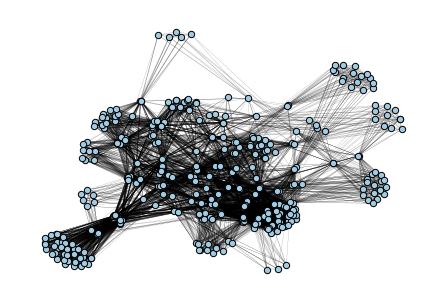

In [9]:
nx.draw(G, node_size=40, edgecolors='#000000', node_color='#A0CBE2', width = 0.1)

### MOVE Network

Next we will do the **MOVE** network. For this network we make a directed graph by taking the page of every **MOVE** that we collected and adding an edge from the **MOVE** to every Pokémon that is linked to on its page. We assume that a Pokémon can learn the given **MOVE** if it is linked to on the page. We also limit the **MOVE**s to be introduced in generations 1-3, since many of the later introduced **MOVE**s can only be taught to Pokémon from those generations. This also ensures that the Pokémon in the network are not severely outnumbered by moves.

In [6]:
mG = nx.DiGraph()
pattern2_2 = r'\{\{Moveentry\/\d\|.*?\|(.*?)\|type'
pattern2_3 = r'\{\{MoveInfobox(?:.*?)gen=(\w*)'
gens = ['I','II','III']

for file in os.listdir("move_text/"):
    
    # move name
    mv = file.replace('.txt','')
    
    f = open(f"move_text/{file}", "r")
    f_text = f.read()
    
    # teachable pokemon
    pkmn = re.findall(pattern2_2, f_text)
    gen = re.search(pattern2_3, f_text, flags=re.S)[1]
    
    # get only the pokemon in our dataframe and moves in gen 1-3
    dfpkmn = [p for p in np.unique(pkmn) if (p in df.Name.values) & (gen in gens)]
    
    # add edges
    mG.add_edges_from([(mv,p) for p in dfpkmn])

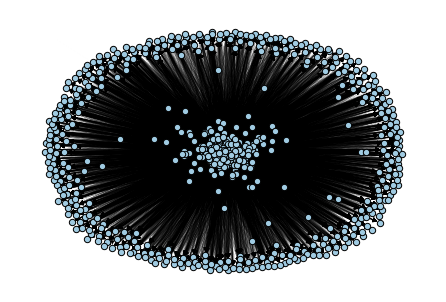

In [193]:
nx.draw(mG, node_size=40, edgecolors='#000000', node_color='#A0CBE2', width = 0.1)

## Network Tools and Data Strategies

In this section I will be explaining which methods I have decided to use and what their purpose is. I have split it into two subsections, **Network** and **Text**, where I will explain the use of networking science tools and natural language processing respectively.

### Network

The first thing we will be looking at is the network science tools we use to learn things about our networks. First we have some basic stats about size and degree. We will then be looking at the degree distributions of the networks and finally we will use an algorithm to divide the networks into communities.

We need to keep in mind that we do not have just a single network, but we have both a network based on the **TYPE**s of our Pokémon and a network based on their movesets and our goal is to compare the results of the two. One of them is also undirected, while the other is a directed graph. That has some meaning for the statistics and distributions, but later we will convert the directed graph to an undirected one.

#### Basic statistics

Firstly we will do some basic statistics about size and average degree along with a small visualization.

#### Degree distributions

Next we will be looking at the degree distributions of the two networks. Degree distributions can tell us  a lot about our networks. It can tell us if our networks contains any hubs and how its connections are distributed. We will also explore who the most connected Pokémon and **MOVE**s are in this section. From this we will be able to tell which **MOVE**s can be learned by the most Pokémon and which Pokémon are the most versatile in terms of their moveset.

#### Communities

In order to find communities within our networks, we will need to use the Louvain algorithm. The Louvain algorithm uses something called modularity optimization. The modularity of a network is a measure of the degree to which densely connected compartments within the network can be split into separate communities where the members are more interconnected.

The Louvain algorithm optimizes this parameter by removing and inserting each node in a different community one by one until there is no significant increase in modularity. The algorithm will then aggregate the communities by merging them into a single giant node and then repeat.[[3]](https://en.wikipedia.org/wiki/Louvain_method)[[4]](https://towardsdatascience.com/louvain-algorithm-93fde589f58c)

We want to compare these communities for the **TYPE** network and the **MOVE** network. We are interested in seeing which communities the members in the communities in the one network are distributed in. We could see if the communities based on **TYPE** also are capable of learning the same moves.


### Text
We have a lot of text that we want to analyze, but how do we do that? The answer is of course Natural Language Processing. We have a few tools to use in order to further strip the data down to its essentials and we have some methods that tell us about that data. In this section we will be focusing on Wordclouds and Sentiment analysis.

#### Wordclouds

We are interested in doing some cool visualizations with wordclouds in order to show what kind of words are associated with each **TYPE** of Pokémon. This is going to involve scraping more text from the individual Pokémon pages. Each Pokémon has a description of them, their physiology, their characteristics, and their behavior. We will use this text to create our wordclouds. Once we have extracted the text we will clean the data and then begin the text processing.

$$\text{Tokenize} \rightarrow \text{Remove stopwords and punctuation} \rightarrow \text{Lemmatize}$$

- First we tokenize, which is the process of turning full texts into lists of tokens. From this we get a list of individual words along with some punctuation and symbols.
- We then remove stopwords and punctuation i.e. words such as 'is', 'the', 'and', which do not tell us a lot about the text.
- Finally we lemmatize in order to get the base dictionary form of a word instead of its plurals or conjugations, i.e. horses $\rightarrow$ horse, running $\rightarrow$ run, and so on.

We should then be able to make a wordcloud with this new list, where the size of each word is dependent on the amount of occurrences in the text. We will start by making a wordcloud for each of the three starter **TYPE**s, Water, Fire, and Grass, but it could be expanded to every **TYPE**. We do this by joining the text from every Pokémon with one of those **TYPE**s and doing the process above on the collective joined text.

#### Sentiment analysis

We are also interested in the sentiment of each individual Pokémon and the communities. We would like to see if we can say something about the sentiment of the community as a whole. It makes the most sense to do this with the **TYPE** network communities, since we want to know if some **TYPE**s are happier/more positive than others. One might assume that Fairy **TYPE** Pokémon in general are happier than for example Ghost **TYPE** Pokémon. We will be doing the sentiment analysis of each Pokémon based on their PokéDex entries.

To do this sentiment analysis we have two methods and we will be using both in this project: 

One is the LabMT method, where we have a dictionary of words and their average happiness. We can use the dictionary to look up each word in the PokéDex entries and then do an average of the values of all the words to gain our total happiness score.

The other method is the VADER method, which is similarly a dictionary based approach. VADER can however take in a sentence and, based on the sentiment rating of the words, give an estimate of how negative, neutral or positive a given sentence is. It will give us a compound score between -1 and 1 and we will use this to score our PokéDex entries.[[5]](https://github.com/cjhutto/vaderSentiment)


## Using the tools

### Network statistics

Here we do a few basic statistics about the networks

#### TYPE Network

In [7]:
num_nodes = len(G.nodes)
num_links = G.size()

avg_deg = np.mean([deg for name, deg in G.degree()])

print(f'Number of nodes in the network: {num_nodes}')
print(f'Number of edges in the network: {num_links}')
print(f'The average degree of a node: {avg_deg}')

Number of nodes in the network: 386
Number of edges in the network: 11098
The average degree of a node: 57.50259067357513


#### MOVE Network

In [8]:
num_nodes = len(mG.nodes)
num_links = mG.size()

avg_deg = np.mean([deg for name, deg in mG.degree()])

print(f'Number of nodes in the network: {num_nodes}')
print(f'Number of edges in the network: {num_links}')
print(f'The average degree of a node: {avg_deg}')

Number of nodes in the network: 739
Number of edges in the network: 17952
The average degree of a node: 48.58457374830852


### Visualization

We do a couple of visualizations based on the Force Atlas 2 algorithm. For these visualizations we color the nodes based on their main **TYPE** (type1 in the DataFrame). We also color **MOVE**s as a single color even though **MOVE**s can also have **TYPE**s. This is not relevant to this project however.

#### TYPE Network

100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 327.31it/s]


BarnesHut Approximation  took  1.75  seconds
Repulsion forces  took  2.38  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  1.40  seconds
AdjustSpeedAndApplyForces step  took  0.27  seconds


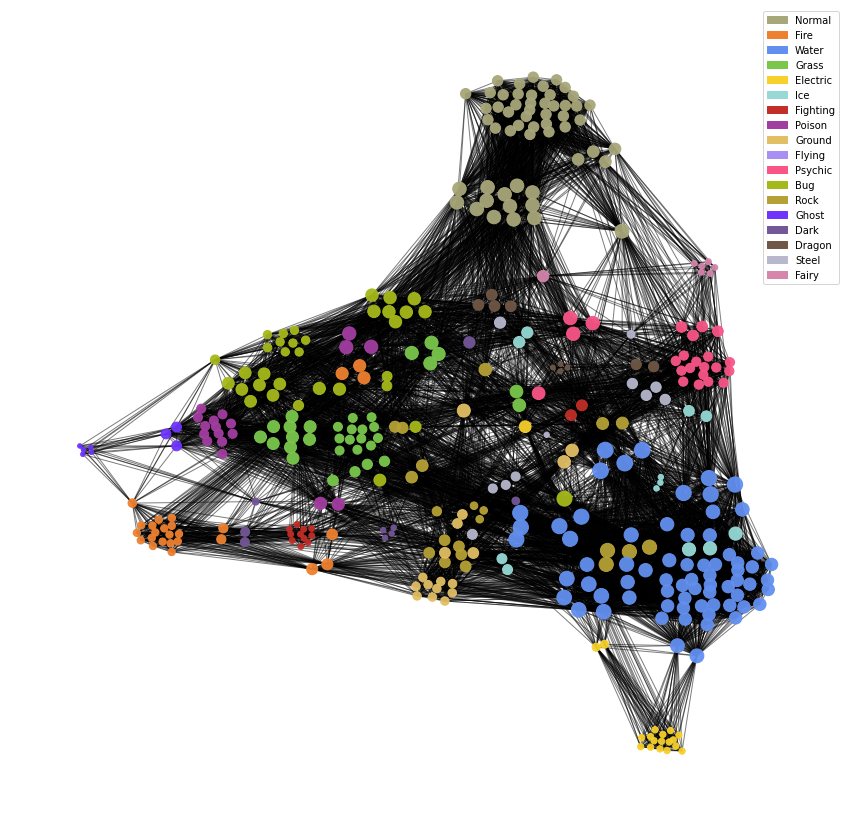

In [9]:
# Color and scale nodes
type_colors = ['#A8A77A','#EE8130','#6390F0','#7AC74C','#F7D02C','#96D9D6','#C22E28','#A33EA1','#E2BF65','#A98FF3',
'#F95587','#A6B91A','#B6A136','#6F35FC','#735797','#705746','#B7B7CE','#D685AD']

node_color = [type_colors[types.index(t)] for t in df.type1]
node_size = [2*G.degree(n) for n in G.nodes()]

# Force Atlas 2 code implemented based on https://github.com/bhargavchippada/forceatlas2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

## Draw
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, positions, node_size=node_size, node_color=node_color, alpha=0.95)
nx.draw_networkx_edges(G, positions, edge_color="black", alpha=0.5)

## Add legend
patches = []
for i in range(len(type_colors)):
    patch = mpatches.Patch(color=type_colors[i], label=types[i])
    patches.append(patch)
plt.legend(handles=patches)

plt.axis('off')
plt.show()

#### Move Network

In [10]:
mG_ud = mG.to_undirected()

100%|██████████████████████████████████████| 2000/2000 [00:13<00:00, 143.90it/s]


BarnesHut Approximation  took  3.59  seconds
Repulsion forces  took  7.70  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  1.72  seconds
AdjustSpeedAndApplyForces step  took  0.39  seconds


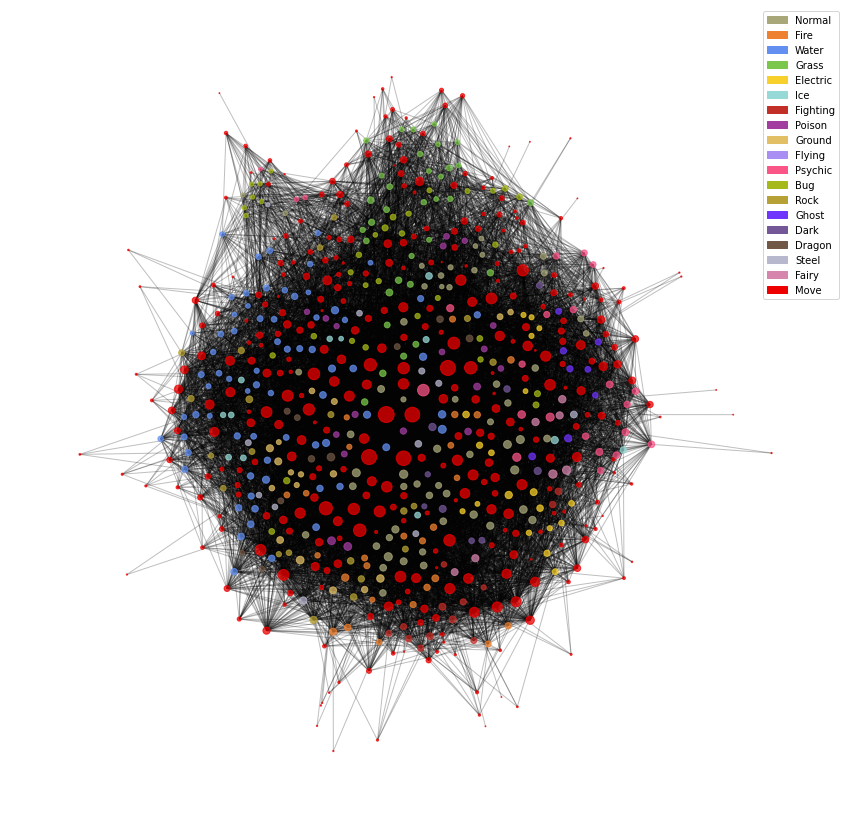

In [11]:
# Color and scale nodes
type_colors = ['#A8A77A','#EE8130','#6390F0','#7AC74C','#F7D02C','#96D9D6','#C22E28','#A33EA1','#E2BF65','#A98FF3',
'#F95587','#A6B91A','#B6A136','#6F35FC','#735797','#705746','#B7B7CE','#D685AD', '#EE0000']

classifier = [df.type1[df.Name == n].values[0] if n in df.Name.values else 'Move' for n in mG_ud.nodes()]
node_color_mv = [type_colors[types.index(t)] for t in classifier]
node_size_mv = [.8*mG_ud.degree(n) for n in mG_ud.nodes()]

# Force Atlas 2 code implemented based on https://github.com/bhargavchippada/forceatlas2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=.5,

                        # Log
                        verbose=True)

positions_mv = forceatlas2.forceatlas2_networkx_layout(mG_ud, pos=None, iterations=2000)

## Draw
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(mG_ud, positions_mv, node_size=node_size_mv, node_color=node_color_mv, alpha=0.75)
nx.draw_networkx_edges(mG_ud, positions_mv, edge_color="black", alpha=0.25)

## Add legend
patches = []
for i in range(len(types)):
    patch = mpatches.Patch(color=type_colors[i], label=types[i])
    patches.append(patch)
plt.legend(handles=patches)

plt.axis('off')
plt.show()

We see that our **TYPE** network is nicely split into what could be communities already, while the **MOVE** network looks a bit more messy. This is because a lot of the **MOVE**s can be taught to many different Pokémon, and the **MOVE**s make up about half of the nodes. It will look a bit prettier, when we do our community analysis later.

## Degree distribution

We take a look at the degree distributions of both of our networks as well as the most and least connected nodes.

### TYPE Network

For the **TYPE** network, there are no nodes with a degree of 0. We know that the ones with the highest degree will be those Pokémon with the **TYPE** combination of the two most numerous **TYPE**s. In this case, the most numerous **TYPE**s are Water and Normal. There is no Pokémon with both of these **TYPE**s, but there are Water and Flying **TYPE** combinations, Flying being the 3rd most common **TYPE**, so these Pokémon will be the most connected by design and they will all have the same degree. Similarly the Pokémon with the lowest degrees will be single type Pokémon of the least numerous type, which is the Ghost **TYPE**.

#### Most and least connected pokemon

In [12]:
## Get the number of Pokémon with a given TYPE
deg_type = {}

for t in types[:-1]:
    pkmn_t = df[(df.type1 == t) | (df.type2 == t)]
    deg_type[t] = pkmn_t.shape[0]

## Sorting the numbers
deg_type_sort = sorted(deg_type, key=deg_type.get, reverse=True)

for t in deg_type_sort:
    print(f'The number of {t} type Pokémon is: {deg_type[t]}')

The number of Water type Pokémon is: 78
The number of Normal type Pokémon is: 55
The number of Flying type Pokémon is: 50
The number of Psychic type Pokémon is: 44
The number of Poison type Pokémon is: 42
The number of Grass type Pokémon is: 41
The number of Ground type Pokémon is: 37
The number of Bug type Pokémon is: 36
The number of Rock type Pokémon is: 30
The number of Fire type Pokémon is: 28
The number of Electric type Pokémon is: 21
The number of Fighting type Pokémon is: 18
The number of Fairy type Pokémon is: 18
The number of Ice type Pokémon is: 16
The number of Dark type Pokémon is: 16
The number of Steel type Pokémon is: 15
The number of Dragon type Pokémon is: 13
The number of Ghost type Pokémon is: 11


In [13]:
top_pkmn = sorted([(deg,name) for name,deg in G.degree], reverse=True)[:5]
bot_pkmn = sorted([(deg,name) for name,deg in G.degree], reverse=False)[:5]

print(f'The 5 most connected pokemon by degree are:\n')

for deg, name in top_pkmn:
    print(f'{name} with a degree of {deg}')

print(f'\nThe 5 least connected pokemon by degree are:\n')

for deg, name in bot_pkmn:
    print(f'{name} with a degree of {deg}')

The 5 most connected pokemon by degree are:

Wingull with a degree of 123
Pelipper with a degree of 123
Mantine with a degree of 123
Gyarados with a degree of 123
Starmie with a degree of 117

The 5 least connected pokemon by degree are:

Banette with a degree of 10
Dusclops with a degree of 10
Duskull with a degree of 10
Misdreavus with a degree of 10
Shuppet with a degree of 10


#### Degrees by type

#### Distribution plots

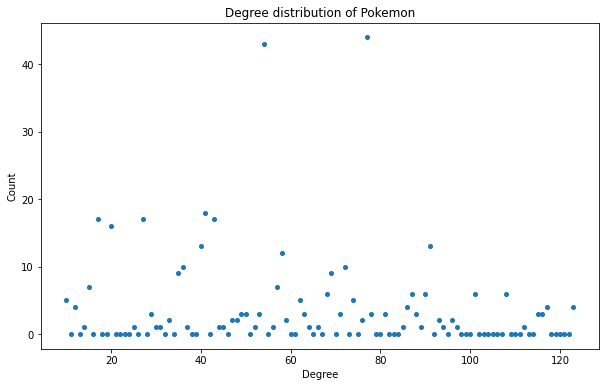

In [29]:
## Making the degree distribution
deg_list = [G.degree(n) for n in G.nodes()]

gmax, gmin = (np.amax(deg_list), np.amin(deg_list))

v = np.arange(gmin,gmax+2)

hist, bins = np.histogram(deg_list, bins=v)

fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(bins[:-1], hist, 'o', markersize='4')
ax.set(title='Degree distribution of Pokemon', xlabel='Degree', ylabel='Count')

plt.show()

We see in the distribution plot above that it looks very unlike any other distribution plot seen before in the course. This, like many of the other network characteristics, is because of how we have connected the nodes. We know from looking at the least connected nodes that no node has a degree of less than 10, and the number of Pokémon with a degree of 10 will be the same as the amount of Pokémon with exclusively the Ghost **TYPE**. This means that in this distribution plot we can see exactly the number of combinations of types and how many fall into those categories. We can for example see only two degrees with a count above 40. These are almost certainly the Pokémon that are ONLY Water or ONLY Normal **TYPE**s, since most Pokémon of those two **TYPE**s are only that **TYPE**. There are also a few degrees with only one or two counts. These will be the unique **TYPE** combinations. A few examples of these are the Pokémon Girafarig (Normal & Psychic),  Heracross (Bug & Fighting), and Poliwrath (Water & Fighting).

### MOVE Network

The most connected nodes in the **MOVE** network will be very different from the **TYPE** network. Here we have instead connected every **MOVE** to every Pokémon that has the ability to learn the **MOVE** at some point. This means that the most connected nodes in terms of in degree will only be Pokémon, and they will be the Pokémon that are the most versatile i.e. able to learn the most moves. Similarly the most connected nodes in terms of out degree will only be **MOVE**s and they will be the **MOVE**s that can be learned by most Pokémon. We won't look at the least connected nodes, since we know that all the Pokémon will have an out degree of 0 and the **MOVE**s will similarly have an in degree of 0 because of how the network was built.

#### Top 5 connected pokemon and moves

In [14]:
top_in = sorted([(deg,name) for name,deg in mG.in_degree], reverse=True)[:5]
top_out = sorted([(deg,name) for name,deg in mG.out_degree], reverse=True)[:5]

print(f'The top 5 connected moves in terms of out degree are:\n')

for deg, name in top_out:
    print(f'{name} with a degree of {deg}')
    
print(f'\nThe top 5 connected pokemon in terms of in degree are:\n')

for deg, name in top_in:
    print(f'{name} with a degree of {deg}')

The top 5 connected moves in terms of out degree are:

Headbutt with a degree of 319
Body Slam with a degree of 285
Sunny Day with a degree of 283
Rain Dance with a degree of 273
Mud-Slap with a degree of 267

The top 5 connected pokemon in terms of in degree are:

Mew with a degree of 170
Clefable with a degree of 88
Clefairy with a degree of 87
Snorlax with a degree of 86
Mewtwo with a degree of 84


#### Distribution plots

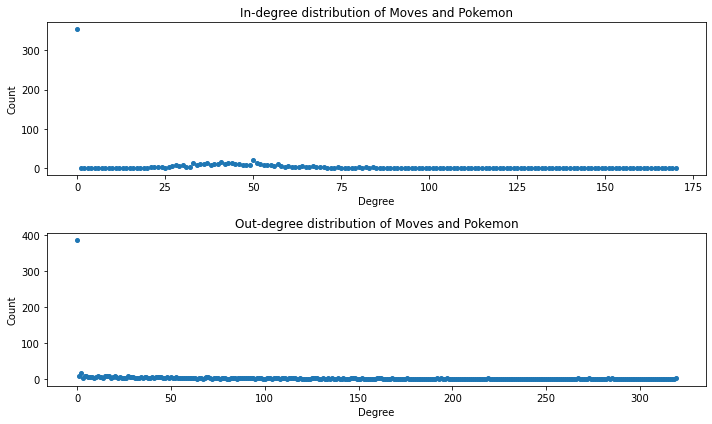

In [31]:
in_list = [mG.in_degree(n) for n in mG.nodes()]
out_list = [mG.out_degree(n) for n in mG.nodes()]

in_gmax, in_gmin = (np.amax(in_list), np.amin(in_list))
out_gmax, out_gmin = (np.amax(out_list), np.amin(out_list))

v_in = np.arange(in_gmin,in_gmax+2)
v_out = np.arange(out_gmin, out_gmax+2)

in_hist, in_bin = np.histogram(in_list, bins=v_in)
out_hist, out_bin = np.histogram(out_list, bins=v_out)

fig, ax = plt.subplots(2,1, figsize=(10,6))

ax[0].plot(in_bin[:-1], in_hist, 'o', markersize='4')
ax[0].set(title='In-degree distribution of Moves and Pokemon', xlabel='Degree', ylabel='Count')

ax[1].plot(out_bin[:-1], out_hist, 'o', markersize='4')
ax[1].set(title='Out-degree distribution of Moves and Pokemon', xlabel='Degree', ylabel='Count')

fig.tight_layout()
plt.show()

Here we see the consequences of how we built the network. There are more than 300 nodes with an in degree of 0. These are all the **MOVE**s. There are also close to 400 nodes with an out degree of 0. These are all the Pokémon. We can see, however, that the Pokémon are mostly concentrated between a degree of 25-75, while the **MOVE**s are more widely distributed, although there are still more **MOVE**s with a degree between 1-150 than with a degree between 150-300. We can also get a sense of this divide when looking at the most connected Pokémon/**MOVE**s above. We see that Mew is the most connected Pokémon with a degree of almost double the next most connected Pokémon, while all the top five **MOVE**s are in the 260-320 range. 

## Communities

Now we are going to partition our two networks into communities, and then we will compare the Pokémon in each community to see, if there is any overlap and how much. We use the Louvain algorithm to make the partition.

### Type Network

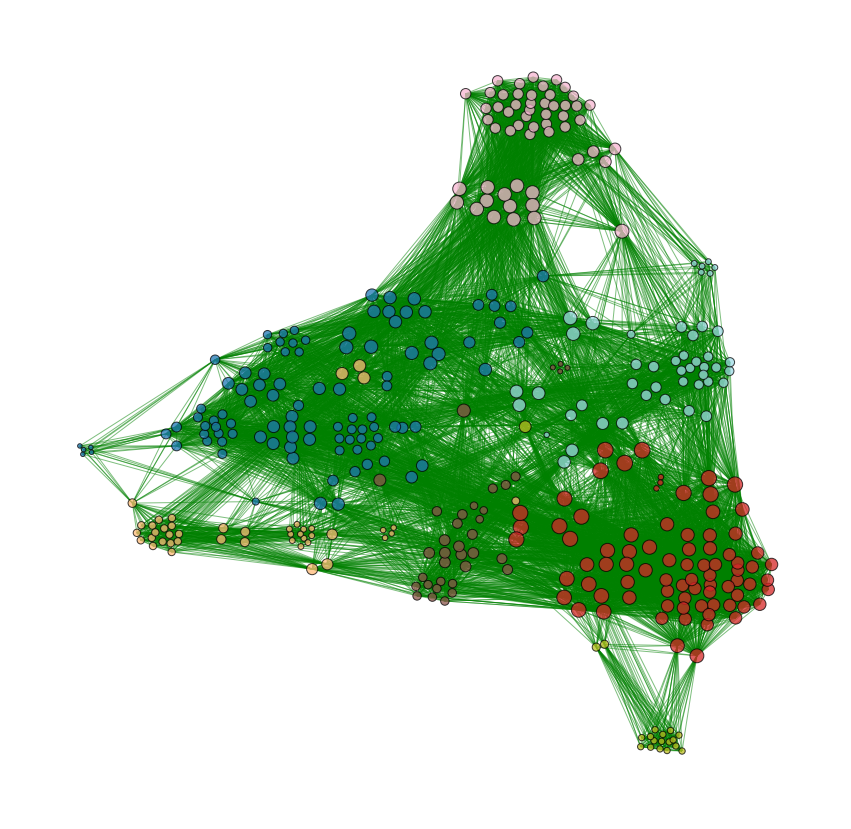

In [25]:
## Compute best partition
partition_type = community_louvain.best_partition(G)

## Color the nodes according to their partition
cmap = cm.get_cmap('tab20', max(partition_type.values())+1)

plt.figure(figsize=(15,15))

## Positions taken from the force atlas 2 algorithm from previous part
nx.draw_networkx_nodes(G, positions, node_size=node_size, cmap=cmap, node_color=list(partition_type.values()), alpha=0.75, edgecolors='black')
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.5)

plt.axis('off')
plt.show()

There are a total of 7 communities
The modularity of the partition is: 0.5477604120708895


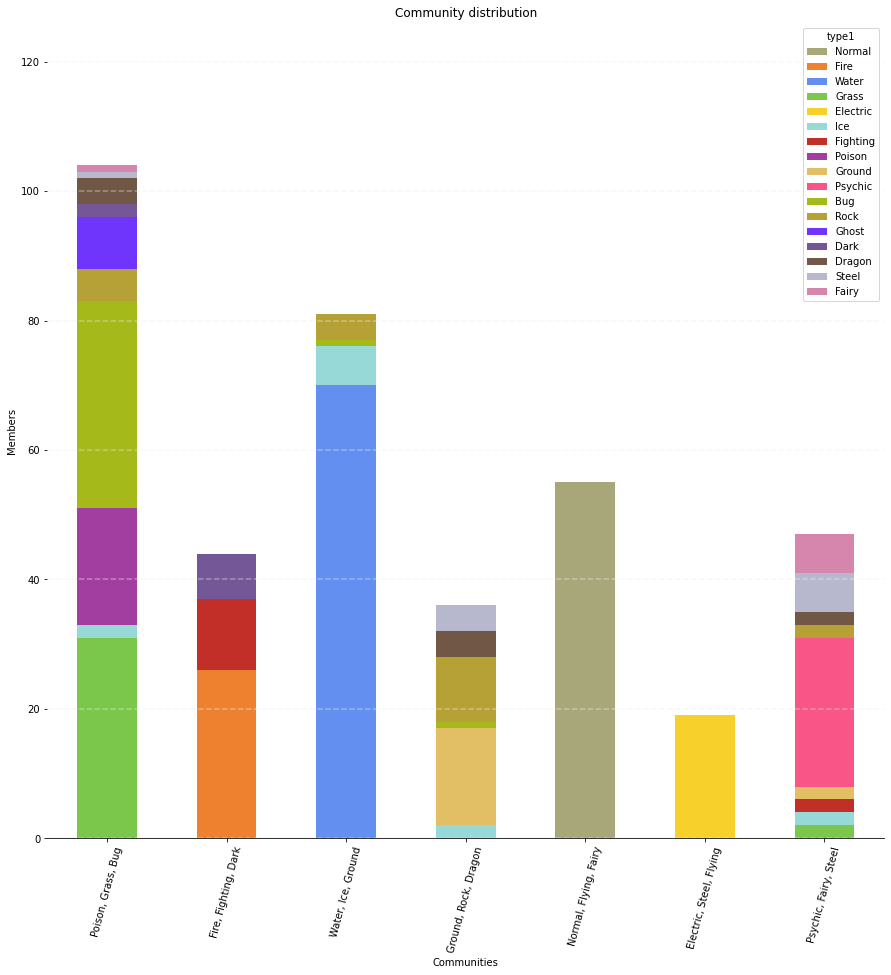

In [26]:
## Create dataframe from the community partition
df_comm_type = pd.DataFrame.from_dict(partition_type, columns=['Community'], orient='index')
df['type_community'] = df_comm_type['Community'].values
num_comms = max(partition_type.values())+1

## Number of communities
print(f'There are a total of {num_comms} communities')

## Modularity
print(f'The modularity of the partition is: {community_louvain.modularity(partition_type, G)}')

## Name communities by top 3 most common types, main or secondary
comm_names_type = []
comm_members_type = []

for i in range(num_comms):
    comm_chars = df_comm_type.index[df_comm_type.Community == i].values
    temp_df = df[df.Name.isin(comm_chars)]
    num_types = {}
    for t in types[:-1]:
        temp_t = temp_df[(temp_df.type1 == t) | (temp_df.type2 == t)]
        num_types[t] = temp_t.shape[0]
    comm_names_type.append(', '.join(sorted(num_types, key=num_types.get, reverse=True)[:3]))
    
    ## Also get 10 most connected members
    degs = {}
    for ch in comm_chars:
        degs[ch] = G.degree(ch)
    comm_members_type.append(df[df.Name.isin(sorted(degs, key=degs.get, reverse=True)[:10])])

## Community distribution
## Fixing type colors
typemask = np.array([t in np.unique(df['type1']) for t in types], dtype=bool)
typeindx = [t for (t, b) in zip(types, typemask) if b]
colorsort = np.array(type_colors)[typemask]

## Plotting communities and stacking by type
ax = df.groupby(['type1', 'type_community'])\
    .size()\
    .unstack(0)[typeindx]\
    .plot.bar(stacked=True, color=colorsort, figsize=(15,15))

## Removing spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_title('Community distribution')
ax.set_xlabel('Communities')
ax.set_ylabel('Members')
plt.xticks(np.arange(0,num_comms), labels=comm_names_type, rotation='75')
plt.show()


In the graph above, each community is named based on the 3 most common **TYPE**s present in the community, and the members in the stacked bar plot are colored based on their main **TYPE**. This means that we see no Flying **TYPE**s in the plot, since it turns out that not a single Pokémon has 'Flying' as their main **TYPE**, yet if you remember from our analysis earlier, Flying is the third most common **TYPE**. We also see this in the community names, where the 'Normal' **TYPE** community also has most Flying and Fairy **TYPE**s.

We already see for the **TYPE** network how the communities are formed very much as expected. Since we connected every Pokémon of any **TYPE** with every Pokémon of that same **TYPE**, we expected the communities to form based on the most common **TYPE** combinations, and that is indeed the case. We see the 'Poison, Grass, Bug' community, which are very common **TYPE** combinations. 

More common **TYPE** combinations are 'Fire' and 'Fighting', 'Water' and 'Ice', 'Normal' and 'Flying', 'Ground' and 'Rock. Furthermore some of the communities consist almost entirely of a single type, and we see that these **TYPE**s are some of the ones, where many of the Pokémon belonging to that **TYPE** only have a single **TYPE** like Electric or Normal. 

There is also an outlier community with many different **TYPE**s, and that is the 'Psychic, Fairy, Steel' community. This also makes sense, since these **TYPE**s, Psychic and Steel specifically, have some of the widest **TYPE** combinations i.e. are typically combined with almost every other **TYPE**.

The last thing worth noting is some of the small communities like Ghost and Dark have latched themselves onto bigger communities that they share a few **TYPE** combinations with. Ghost for example has only 3 Pokémon with the Poison **TYPE**, namely the evolution family Ghastly, Haunter and Gengar, but since the other 8 Ghost Pokémon barely have any other secondary **TYPE**s, they have 'hitched a ride', so to speak, with the Poison community.

### Move Network

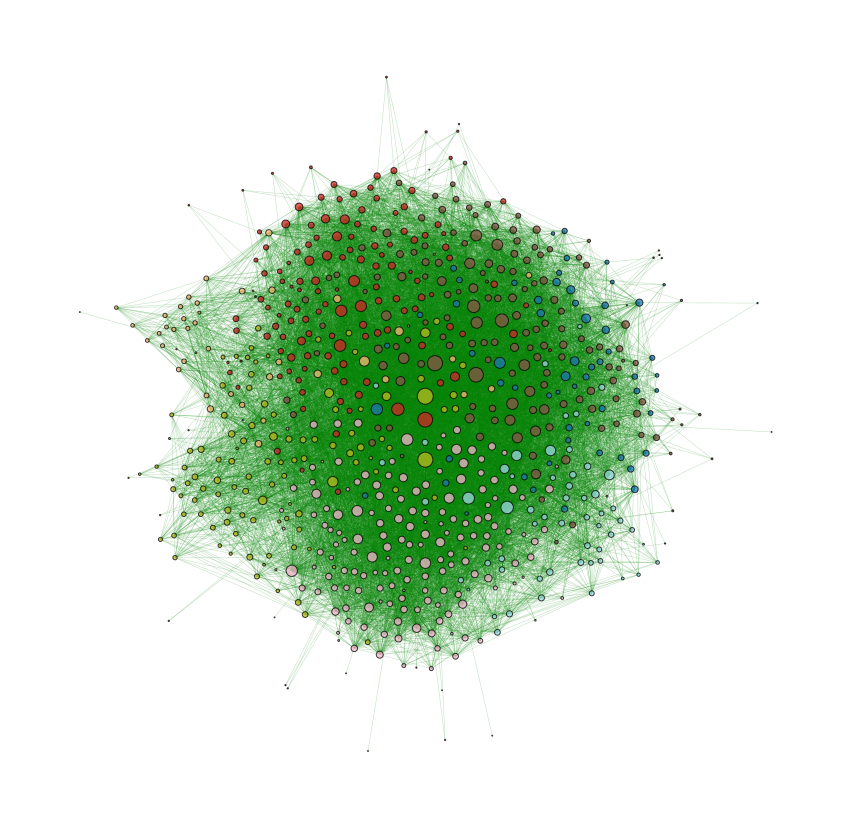

In [21]:
## Compute best partition
partition_move = community_louvain.best_partition(mG_ud)

## Color the nodes according to their partition
cmap = cm.get_cmap('tab20', max(partition_move.values())+1)

plt.figure(figsize=(15,15))

## Positions taken from the force atlas 2 algorithm from previous part
nx.draw_networkx_nodes(mG_ud, positions_mv, node_size=node_size_mv, cmap=cmap, node_color=list(partition_move.values()), alpha=0.75, edgecolors='black')
nx.draw_networkx_edges(mG_ud, positions_mv, edge_color="green", alpha=0.25, width=0.5)

plt.axis('off')
plt.show()

There are a total of 7 communities
The modularity of the partition is: 0.2579326073108205


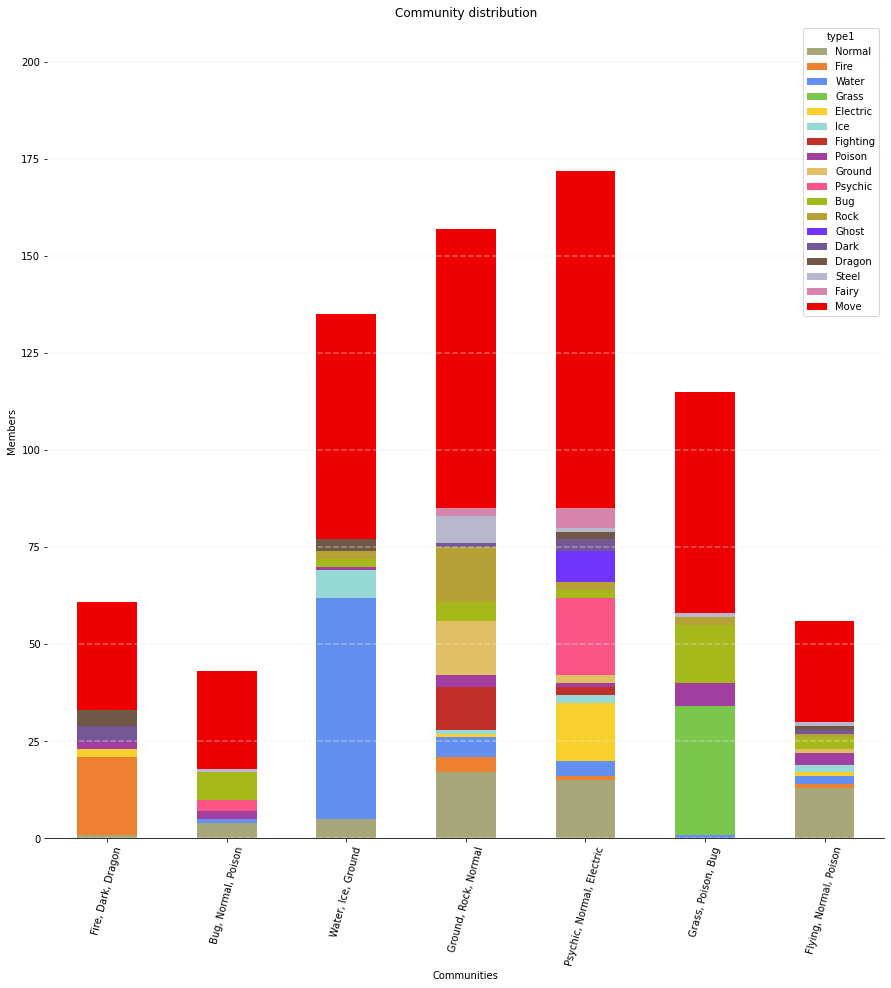

In [23]:
## Create dataframe from the community partition
df_comm_mv = pd.DataFrame.from_dict(partition_move, columns=['Community'], orient='index').rename_axis('Name').reset_index()
df_comm_mv['type1'] = [df.type1[df.Name == n].values[0] if n in df.Name.values else 'Move' for n in df_comm_mv.Name]
num_comms_mv = max(partition_type.values())+1

## Fix index of MOVE dataframe and add MOVE communities to original dataframe
tempdf = df_comm_mv[df_comm_mv.type1 != 'Move']

tempdf = tempdf.set_index('Name')
tempdf = tempdf.reindex(index=df['Name'])
tempdf = tempdf.reset_index()

df['move_community'] = tempdf.Community.values

## Number of communities
print(f'There are a total of {num_comms_mv} communities')

## Modularity
print(f'The modularity of the partition is: {community_louvain.modularity(partition_move, mG_ud)}')

## Name communities by top 3 most common types
comm_names_mv = []
comm_members_pkmn = []
comm_members_mv = []

for i in range(num_comms_mv):
    comm_chars = df_comm_mv.Name[df_comm_mv.Community == i].values
    temp_df = df[df.Name.isin(comm_chars)]
    num_types = {}
    for t in types[:-1]:
        temp_t = temp_df[(temp_df.type1 == t) | (temp_df.type2 == t)]
        num_types[t] = temp_t.shape[0]
    comm_names_mv.append(', '.join(sorted(num_types, key=num_types.get, reverse=True)[:3]))
    
    ## Also get 10 most connected Pokémon
    degs_pkmn = {}
    for ch in comm_chars:
        degs_pkmn[ch] = mG.in_degree(ch)
    comm_members_pkmn.append(df[df.Name.isin(sorted(degs_pkmn, key=degs_pkmn.get, reverse=True)[:10])])
    
    ## Also get 5 most connected MOVEs
    degs_mv = {}
    for ch in comm_chars:
        degs_mv[ch] = mG.out_degree(ch)
    comm_members_mv.append(df_comm_mv[df_comm_mv.Name.isin(sorted(degs_mv, key=degs_mv.get, reverse=True)[:10])])

## Community distribution
## Fixing type colors
typemask_mv = np.array([t in np.unique(df_comm_mv['type1']) for t in types], dtype=bool)
typeindx_mv = [t for (t, b) in zip(types, typemask_mv) if b]
colorsort_mv = np.array(type_colors)[typemask_mv]

## Plotting communities and stacking by type
ax = df_comm_mv.groupby(['type1', 'Community'])\
    .size()\
    .unstack(0)[typeindx_mv]\
    .plot.bar(stacked=True, color=colorsort_mv, figsize=(15,15))

## Removing spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

ax.set_title('Community distribution')
ax.set_xlabel('Communities')
ax.set_ylabel('Members')
plt.xticks(np.arange(0,num_comms_mv), labels=comm_names_mv, rotation='75')
plt.show()


In the graph above, the names of the communities are once again based on the most frequent **TYPE**s of Pokémon with that community. There are however a few key differences from the similar graph we got from the **TYPE** network. We see that about half of each community consists of **MOVE**s. 

The communities are also much more mixed in terms of the main **TYPE** of the Pokémon. While some communities are still mostly intact, others have been split amongst the other communities. The 'Water, Ice, Ground' community is for example also present here and does not seem to have changed too much. Similarly 'Grass, Poison, Bug' is also mostly the same. But then we look at the Normal community, which seems to have been split up amongst the other communities. 

Interestingly, it seems that the Fighting **TYPE**s have joined the 'Ground, Rock' community and the Electric and Ghost **TYPE**s have joined the 'Psychic' community. There is a very good reason for this. We know that every damaging **MOVE** has a **TYPE** in order to deal super effective or not so effective damage based on the **TYPE** of the defending Pokémon, but **MOVE**s are also further categorized into Physical or Special moves, which relies on different stats to do damage. It also happens that Electric, Psychic and Ghost **TYPE**s have mostly Special **MOVE**s, while Ground, Rock and Fighting **TYPE**s have more Physical **MOVE**s. It is likely that these two communities have been split based on these classifications. Both of these communities also have a sizable amount of members with the Normal **TYPE**. This also makes sense, since Normal **TYPE**s are often a jack of all trades, capable of learning a wide pool of **MOVE**s.

Lastly we note that, besides Physical and Special **MOVE**s, there are also Status **MOVE**s, which often change either the stats of a Pokémon or applies a status condition such as Sleep, Burn, Frozen etc. If we look at some of the members of the 'Bug, Normal, Poison' community, which we saved in the `comm_members_mv` and `comm_members_pkmn` array, we see that they in fact have a lot of these **MOVE**s, such as 'Toxic', 'Attract', 'Rest'.


### Community overlap

Now we will see to which degree the Pokémon in these communities overlap. Below we will look at the Pokémon in each of the **MOVE** communities and see where the members are distributed in every **TYPE** community. We will also be looking at the 10 most connected **MOVE**s within that community.

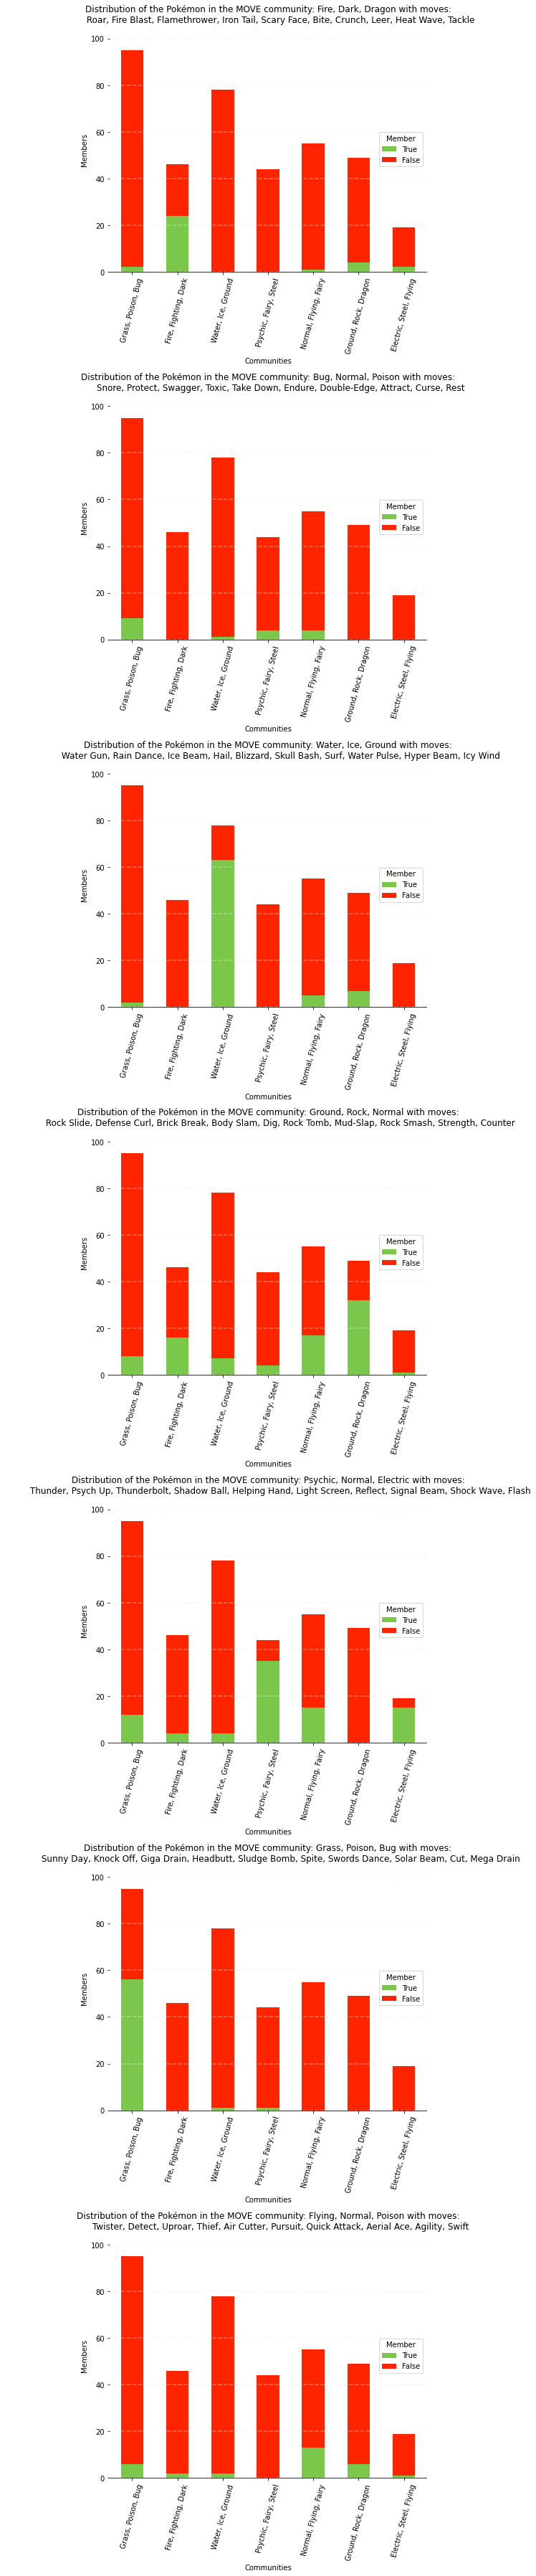

In [37]:
fig, ax = plt.subplots(7,1,figsize=(7,50))

testdf3 = df
for i in range(num_comms):
    testdf3['Member'] = (testdf3.move_community == i).astype(str)

    ## Plotting communities and stacking by type
    ax[i] = testdf3.groupby(['Member', 'type_community'])\
        .size()\
        .unstack(0)[['True','False']]\
        .plot.bar(stacked=True, color=['#7AC74C','#FF2400'], ax=ax[i])
    
    ## Removing spines
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)

    vals = ax[i].get_yticks()
    for tick in vals:
        ax[i].axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    ax[i].set_title(f'Distribution of the Pokémon in the MOVE community: {comm_names_mv[i]} with moves:\n \
        {", ".join(comm_members_mv[i].Name.values)}')
    ax[i].set_xlabel('Communities')
    ax[i].set_ylabel('Members')
    ax[i].set_xticks(np.arange(0,num_comms), labels=comm_names_type, rotation='75')
    
fig.tight_layout()
plt.show()

As we see in the plots above, several **MOVE** communities actually have a huge overlap with the respective **TYPE** communities, while some are a little more spread out. There are a few, that I would like to draw attention to. 

If we look at the first **MOVE** community, we see that the top **MOVE**s are mostly Fire **MOVE**s with a few Dark and Normal **MOVE**s. It would make sense for the 'Fire, Dark, Dragon' community to learn these **MOVE**s and we actually see that most of the Pokémon in this **MOVE** community are also a member of the 'Fire, Fighting, Dark' **TYPE** community. Although those members only account for half of the community, this makes sense. While the most common combination for Fighting **TYPE** Pokémon is with Fire, they do in fact not share many of their **MOVE**s. 

Similarly we can see a large overlap in the 'Grass, Poison, Bug' communities and the 'Water, Ice, Ground' communities. We also have a community with the Status effect **MOVE**s as predicted, which is a relatively small community and also spread out and not pertaining to any specific community.

We also see the Physical and Special **MOVE** communities spreading out as predicted. The Physical 'Ground, Rock, Normal' **MOVE** community with **MOVE**s like 'Strength', 'Rock Smash' and 'Body Slam' looks to be split between the Fighting **TYPE** Pokémon in the 'Fire, Fighting, Dark' community, the Ground and Rock **TYPE**s in the 'Ground, Rock, Dragon' community, and a sizable part of the Normal community. Likewise the Special **MOVE** community 'Psychic, Normal, Electric' with **MOVE**s such as 'Thunderbolt', 'Shadow Ball' and 'Shockwave' is spread out to the communities with those **TYPE**s.

Lastly there is one **MOVE** community, which seems to be fairly spread out with a lot of Speed based **MOVE**s such as 'Agility', 'Quick Attack' and 'Aerial Ace'. Many of these **MOVE**s are very typical of the Flying **TYPE**, which makes it no surprise that the top 10 most connected Pokémon within that community all have Flying as a secondary **TYPE**.

We can conclude from these plots that, while there is a sizable overlap between many of the **MOVE**s, the **MOVE**set of an individual Pokémon is heavily based on its **TYPE**, especially for the 3 main **TYPE**s Fire, Grass and Water, and also for Bug and Poison **TYPE**s.

## Wordclouds

### Getting Descriptions

We get the description of each Pokémon of our selection of **TYPE**s and clean the text.

In [27]:
pkmn_list = []
wc_types = ['Water','Grass','Fire']

for t in wc_types:
    pkmn_list.append(df[(df.type1 == t) | (df.type2 == t)])

token_list = []
    
## Text preprocessing
for type_list in pkmn_list:
    type_text = ''
    
    ## Get file
    for name in type_list.Name:
        file = open(f'pokemon_text/{name}.txt', 'r')
        f = file.read()
        type_text += ' ' + re.search(r'==(.*?)=+Game', f, flags=re.S|re.I)[1]
    
    ## Remove headers
    type_text = re.sub(r'(=+)\s*(.*?)\s*(=+)', '', type_text)
    
    ## Removing punctuation manually, since there are problems with doing it automatically
    type_text = re.sub(r'[\!\"\(\)\-\.\,\;\[\]\*\{\}\|\']', '', type_text)

    ## Removing other problematic stuff
    type_text = re.sub(r'[0-9]', '', type_text)
    
    ## Remove names
    for name in df.Name:
        type_text = re.sub(name,'',type_text)
        
    ## Create tokens
    tokens = [s.lower() for s in WordPunctTokenizer().tokenize(type_text)]
    
    ## Remove stopwords and punctuation
    stop_words = stopwords.words('english')
    punctuation = list(punctuation)
    
    cleaned_tokens = [token for token in tokens if token not in stop_words and token not in punctuation]
    
    ## Lemmatizing (disallow single letter words)
    wnl = nltk.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(t) for t in cleaned_tokens if len(t) > 1]
    
    token_list.append(lemmas)
    

Now we can make our wordclouds.

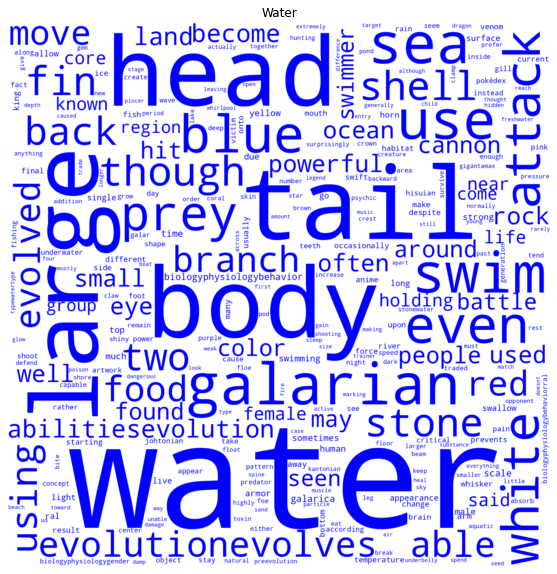

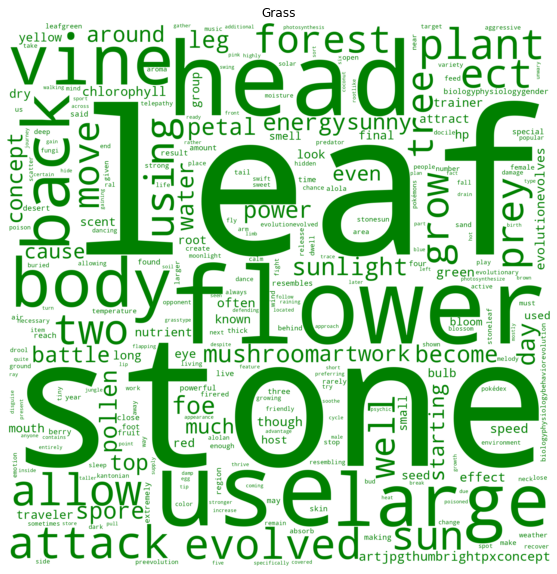

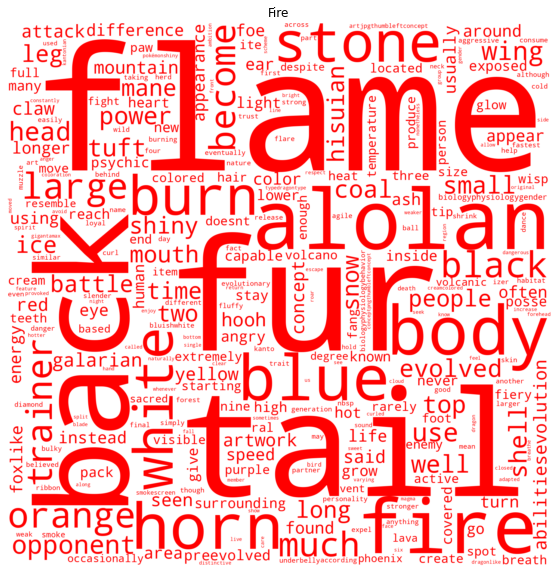

In [33]:
## Removing some words that appear in all wordclouds
words_remove = ['pokémon', 'evolve', 'level', 'biologyphysiology', 'behavior', 'evolution', 'mega', 'ability', 'evolves', 'file', 'form', 'one']
new_token_list = []

for l in token_list:
    new_token_list.append([i for i in l if not i in words_remove])
    
## Wordcloud
color_map = ['blue', 'green', 'red']

for i, tlist in enumerate(new_token_list):
    text = " ".join(t for t in tlist)
    wordcloud = WordCloud(color_func=lambda *args, **kwargs: color_map[i], width=2000, height=2000, max_words=300, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(10,10))
    plt.title(wc_types[i])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Since these wordclouds are made from the descriptions of each Pokémon, it makes sense that the words 'head', 'body' and 'tail' would appear in some way in all of the wordclouds as many Pokémon have some distinct features involving these. It seems like the Fire and Grass **TYPE**s have more distinct features on their backs, Water and Fire **TYPE**s are more likely to have tails. Fire **TYPE**s also have flames, horns and fur, while Grass **TYPE**s have leaves, flowers and vines, and Water **TYPE**s are focused around water and the sea.

Interestingly, all of the different **TYPE**s mention 'stone' in their wordcloud. This is likely to do with their ways of evolving. In the Pokémon games, some Pokémon can only involve when given a special stone. There are Leaf Stones for Grass Pokémon, Fire Stones for Fire Pokémon and Water Stones for Water Pokémon. This is likely why they all mention 'stone'. It looks as though there are more Grass Pokémon, which evolve this way, compared to the other two.

## Sentiment Analysis

As mentioned earlier we will be doing sentiment analysis using both the LabMT and the VADER lexicons. We will start by cleaning the PokéDex entries and then calculate the sentiment for each entry with both methods. Knowing quite a bit about the Pokémon of generations 1-3, I would expect the Pokémon Cubone to have the saddest entry in the PokéDex. We will explore the data and see if this hypothesis holds true.

### LabMT

In [9]:
def get_happiness_LabMT(tokens):
    return np.sum([LabMT.loc[LabMT.word==t, 'happiness_average'].values for t in tokens])/len(tokens)

In [10]:
## Load LabMT
LabMT = pd.read_csv('LabMT.txt', sep='\t', skiprows=2)
LabMT = LabMT[['word','happiness_average']]

## Clean text from pokedex entries
pkdx_clean = []

for name in df.Name:
    subpatterns = [r'\<br\/\>', r'(I+)\n', r'\n', r'[\[\]\'\:\,]']
    pkdx_text = ' '.join(pkdx_entries[name])
    for p in subpatterns:
        pkdx_text = re.sub(p, '', pkdx_text)
    pkdx_clean.append(pkdx_text)


## Calculate sentiment (LabMT)
for i in range(len(pkdx_clean)):

    ## Tokenize
    pkdx_t = WordPunctTokenizer().tokenize(pkdx_clean[i])

    ## Use tokens if they have a happiness value
    cleaned_tokens = [token.lower() for token in pkdx_t if token.lower() in LabMT['word'].values]
    
    ## Calculate sentiment
    sent = get_happiness_LabMT(cleaned_tokens)
    df.loc[i, 'LabMT'] = sent


I opted to not use lemmatization, since it turns the word 'has' to 'ha' which has a widely different happiness value, when the text itself might not be as happy.

In [58]:
from IPython.display import display_html 

## Top 10 happiest pokemon according to LabMT
t10df1 = df[['Name','LabMT']].sort_values(by=['LabMT'], ascending=False)[0:10]

## Top 10 least happy pokemon according to LabMT
t10df2 = df[['Name','LabMT']].sort_values(by=['LabMT'], ascending=True)[0:10]

t10df1_styler = t10df1.style.set_table_attributes("style='display:inline'").set_caption('Top 10 happiest Pokémon')
t10df2_styler = t10df2.style.set_table_attributes("style='display:inline'").set_caption('Top 10 saddest Pokémon')

display_html(t10df1_styler._repr_html_()+t10df2_styler._repr_html_(), raw=True)

,Name,LabMT
369,Luvdisc,5.803629
174,Togepi,5.773494
313,Illumise,5.765543
333,Altaria,5.743558
356,Tropius,5.714140
165,Ledian,5.710768
11,Butterfree,5.683647
310,Plusle,5.683320
95,Drowzee,5.674534
271,Ludicolo,5.668085


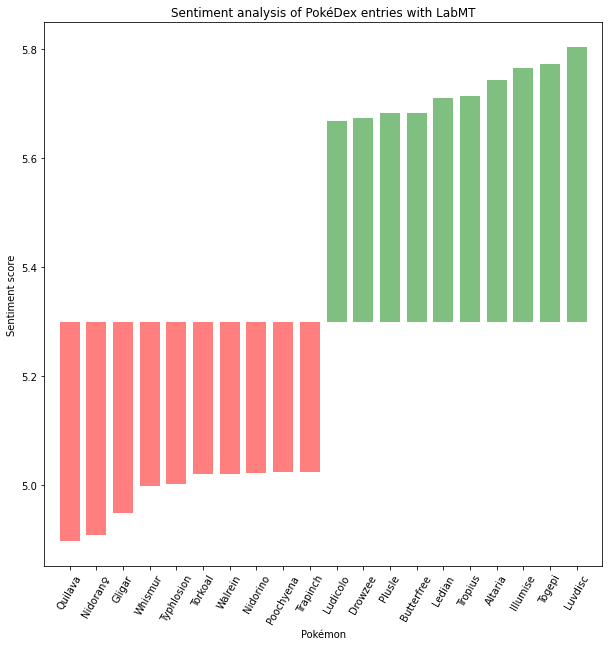

In [62]:
## Quick plotting
plot_df = pd.concat([t10df1,t10df2]).sort_values('LabMT').reset_index()
plot_df['Color'] = ['red' if x < 5.2 else 'green' for x in plot_df['LabMT']]

fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.vlines(x=plot_df.Name, ymin=5.3, ymax=plot_df.LabMT,
           alpha=0.5, linewidth=20, color=plot_df.Color)
ax.set_title('Sentiment analysis of PokéDex entries with LabMT')
ax.set_xlabel('Pokémon')
ax.set_ylabel('Sentiment score')
plt.xticks(rotation=60)
plt.show()

In [51]:
import random

## Luvdisc and Quilava PokeDex entries
luvdisc_entry = pkdx_clean[369].split('.')
quilava_entry = pkdx_clean[155].split('.')

print('Random Luvdisc entries\n')
for e in random.choices(luvdisc_entry, k=3):
    print(e)

print('\nRandom Quilava entries\n')
for e in random.choices(quilava_entry, k=3):
    print(e)

Random Luvdisc entries

 It is said that a couple finding this Pokémon will be blessed with eternal love
  Loving couples have a soft spot for this Pokémon so honeymoon hotels often release this Pokémon into their pools
 In some places you would give a Luvdisc to someone you love

Random Quilava entries

 Before battle it turns its back on its opponent to demonstrate how ferociously its fire blazes
 It means that it will attack with the fire on its back
 The fire burns more strongly when it readies to fight


We can see on some of the entries of the happiest and saddest Pokémon that the happiness ratings make sense for the most part. While the Quilava entries definitely are not positive, I would not call them sad either, so perhaps the LabMT ratings should not be considered happy or sad but positive or negative instead. We also notice that Cubone did not appear on the top 10 saddest Pokémon according to LabMT. We will keep this in mind.

### VADER

In [52]:
## VADER sentiment analysis
sid_obj = SentimentIntensityAnalyzer()

for i, pc in enumerate(pkdx_clean):
    comp = 0
    for s in pc.split('.'):
        
        sentiment_dict = sid_obj.polarity_scores(s)

        comp += sentiment_dict['compound']
        
    df.loc[i, 'Vader'] = comp/len(pc.split('.'))

In [53]:
## Top 10 happiest pokemon according to LabMT
t10df1 = df[['Name','Vader']].sort_values(by=['Vader'], ascending=False)[0:10]

## Top 10 least happy pokemon according to LabMT
t10df2 = df[['Name','Vader']].sort_values(by=['Vader'], ascending=True)[0:10]

t10df1_styler = t10df1.style.set_table_attributes("style='display:inline'").set_caption('Top 10 happiest Pokémon')
t10df2_styler = t10df2.style.set_table_attributes("style='display:inline'").set_caption('Top 10 saddest Pokémon')

display_html(t10df1_styler._repr_html_()+t10df2_styler._repr_html_(), raw=True)

,Name,Vader
174,Togepi,0.724956
175,Togetic,0.433875
369,Luvdisc,0.432000
333,Altaria,0.418400
311,Minun,0.411731
112,Chansey,0.404312
356,Tropius,0.404280
384,Jirachi,0.399193
230,Phanpy,0.358605
280,Kirlia,0.337912


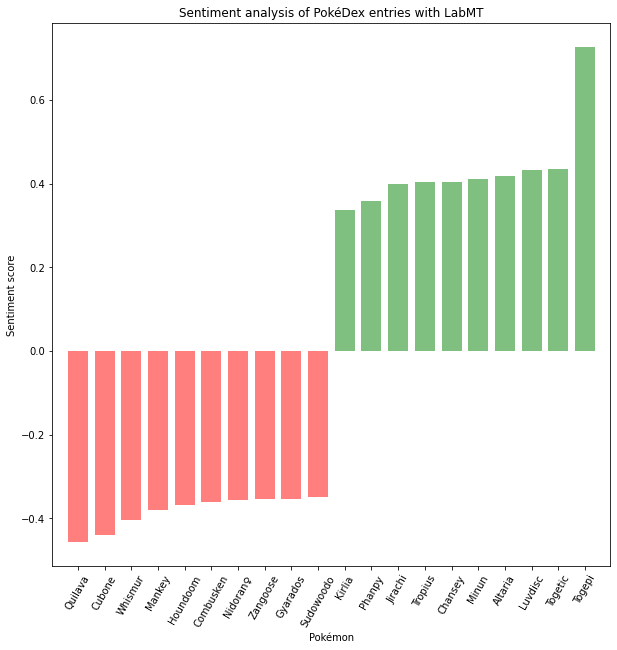

In [56]:
## Quick plotting
plot_df = pd.concat([t10df1,t10df2]).sort_values('Vader').reset_index()
plot_df['Color'] = ['red' if x < 0 else 'green' for x in plot_df['Vader']]

fig, ax = plt.subplots(1,1,figsize=(10,10))

ax.vlines(x=plot_df.Name, ymin=0, ymax=plot_df.Vader,
           alpha=0.5, linewidth=20, color=plot_df.Color)
ax.set_title('Sentiment analysis of PokéDex entries with VADER')
ax.set_xlabel('Pokémon')
ax.set_ylabel('Sentiment score')
plt.xticks(rotation=60)
plt.show()

In [78]:
## Luvdisc and Quilava PokeDex entries
togepi_entry = pkdx_clean[174].split('.')
cubone_entry = pkdx_clean[103].split('.')

print('Random Togepi entries:\n')
for e in random.choices(togepi_entry, k=3):
    print(e)
    scores = sid_obj.polarity_scores(e)
    pos, neu, neg = scores['pos'], scores['neu'], scores['neg']
    print(f'This entry is considered {pos} positive {neu} neutral and {neg} negative\n')

print('\nRandom Cubone entries:\n')
for e in random.choices(cubone_entry, k=3):
    print(e)
    scores = sid_obj.polarity_scores(e)
    pos, neu, neg = scores['pos'], scores['neu'], scores['neg']
    print(f'This entry is considered {pos} positive {neu} neutral and {neg} negative\n')

Random Togepi entries:

 The shell seems to be filled with joy
This entry is considered 0.352 positive 0.648 neutral and 0.0 negative

 It stores up happy feelings in its shell then shares them out
This entry is considered 0.371 positive 0.629 neutral and 0.0 negative

 It is said that it will share good luck when treated kindly
This entry is considered 0.585 positive 0.415 neutral and 0.0 negative


Random Cubone entries:

 Seeing a likeness of its mother in the full moon it cries
This entry is considered 0.0 positive 0.803 neutral and 0.197 negative

 Cubone pines for the mother it will never see again
This entry is considered 0.0 positive 1.0 neutral and 0.0 negative

 When it thinks of its dead mother it cries
This entry is considered 0.0 positive 0.5 neutral and 0.5 negative



We see that when using VADER, the happiest Pokémon is now Togepi and it is not even close, while Quilava is still the saddest Pokémon and looking at the entries we can see why. Since we are using VADER we can also see how it rates each individual sentence. 

Togepi's entries and their ratings definitely makes sense, since they are very happy and positive, but when we look at the entries for Cubone, which is the second saddest Pokémon according to VADER, we see the issue with dictionary-based methods for sentiment analysis.

While many of the entries are correctly classified as negative, some of the entries are classified as 100% neutral, even though we might consider them to be very sad. An example of this is the sentence "Cubone pines for the mother it will never see again", which is rated as 100% neutral, since the VADER scores cannot take the context into account and only rates individual words.

### Sentiment Distributions

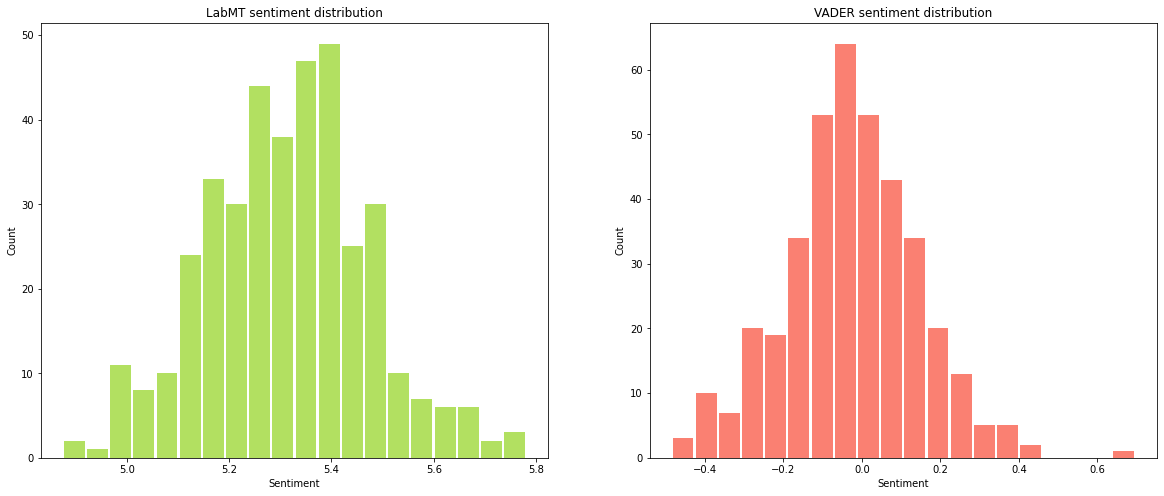

In [112]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

hist, bins = np.histogram(df['LabMT'].values, bins=20)
ax[0].bar(bins[:-1], hist, width=0.9 * (bins[1] - bins[0]), color='#b2e061')
ax[0].set(title='LabMT sentiment distribution', xlabel='Sentiment', ylabel='Count')

hist, bins = np.histogram(df['Vader'].values, bins=20)
ax[1].bar(bins[:-1], hist, width=0.9 * (bins[1] - bins[0]), color='#FA8072')
ax[1].set(title='VADER sentiment distribution', xlabel='Sentiment', ylabel='Count')


plt.show()

## Community sentiments

We look at the average sentiment for each of the communities in both networks. Since VADER performed a bit better according to our expectations, we will be doing analysis of both networks with VADER only.

### Type Network

In [115]:
## Community sentiments type
comm_sents = {}
comm_stds = {}

for i in range(num_comms):
    comm_chars = df_comm_type.index[df_comm_type.Community == i].values
    char_sents = [df.Vader[df.Name == n].values for n in comm_chars if len(df.Vader[df.Name == n].values) > 0]
    
    if len(char_sents) == 0:
        continue
    
    c_sent = np.mean(char_sents)
    c_std = np.std(char_sents)
    
    comm_sents[comm_names_type[i]] = c_sent
    comm_stds[comm_names_type[i]] = c_std
    
top_happy_comms = sorted(comm_sents, key=comm_sents.get, reverse=True)[:3]
top_sad_comms = sorted(comm_sents, key=comm_sents.get, reverse=False)[:3]

print(f'The three happiest communities in the type network are:\n')

for c in top_happy_comms:
    print(c)

print(f'\nThe three saddest communities in the type network are:\n')

for c in top_sad_comms:
    print(c)

The three happiest communities in the type network are:

Psychic, Fairy, Steel
Normal, Flying, Fairy
Water, Ice, Ground

The three saddest communities in the type network are:

Fire, Fighting, Dark
Ground, Rock, Dragon
Grass, Poison, Bug


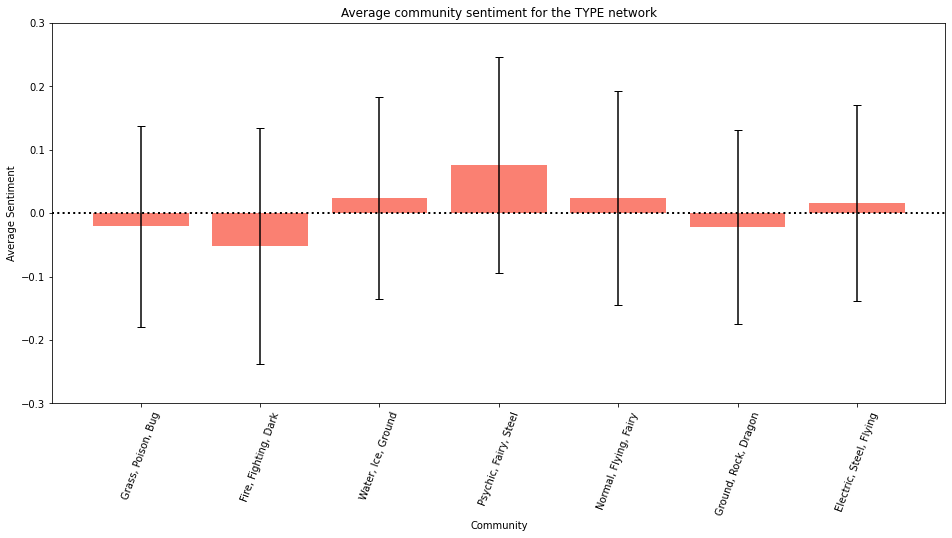

In [116]:
fig, ax = plt.subplots(1,1,figsize=(16,7))

ax.bar(comm_sents.keys(), comm_sents.values(), yerr=comm_stds.values(), color='#FA8072', capsize=4)
ax.set_title('Average community sentiment for the TYPE network')
ax.set_xlabel('Community')
ax.set_ylabel('Average Sentiment')
ax.set_ylim([-.3, .3])
plt.xticks(rotation='70')
plt.axhline(y=0, color='black', linestyle='dotted', linewidth=2)
plt.show()

In the plot above we can see the average sentiment for each of the communities in the **TYPE** network, and just like we would expect, the happiest communities are those that are made up by Fairy **TYPE**s among others. Likewise we might have expected that the least happy communities would consist of Poison or Dark or maybe Ghost **TYPE** Pokémon. We should however note that the average sentiments of all communities are very close to each other and their standard deviations are also very large compared to their means.

### Move Network

In [117]:
## Community sentiments moves
comm_sents = {}
comm_stds = {}

for i in range(num_comms_mv):
    comm_chars = df_comm_mv.Name[df_comm_mv.Community == i].values
    char_sents = [df.Vader[df.Name == n].values[0] for n in comm_chars if len(df.Vader[df.Name == n].values) > 0]
    
    if len(char_sents) == 0:
        continue
    
    c_sent = np.mean(char_sents)
    c_std = np.std(char_sents)
    
    comm_sents[comm_names_mv[i]] = c_sent
    comm_stds[comm_names_mv[i]] = c_std
    
top_happy_comms = sorted(comm_sents, key=comm_sents.get, reverse=True)[:3]
top_sad_comms = sorted(comm_sents, key=comm_sents.get, reverse=False)[:3]

print(f'The three happiest communities in the move network are:\n')

for c in top_happy_comms:
    print(c)

print(f'\nThe three saddest communities in the move network are:\n')

for c in top_sad_comms:
    print(c)

The three happiest communities in the move network are:

Psychic, Normal, Electric
Water, Ice, Ground
Grass, Poison, Bug

The three saddest communities in the move network are:

Bug, Normal, Poison
Ground, Rock, Normal
Fire, Dark, Dragon


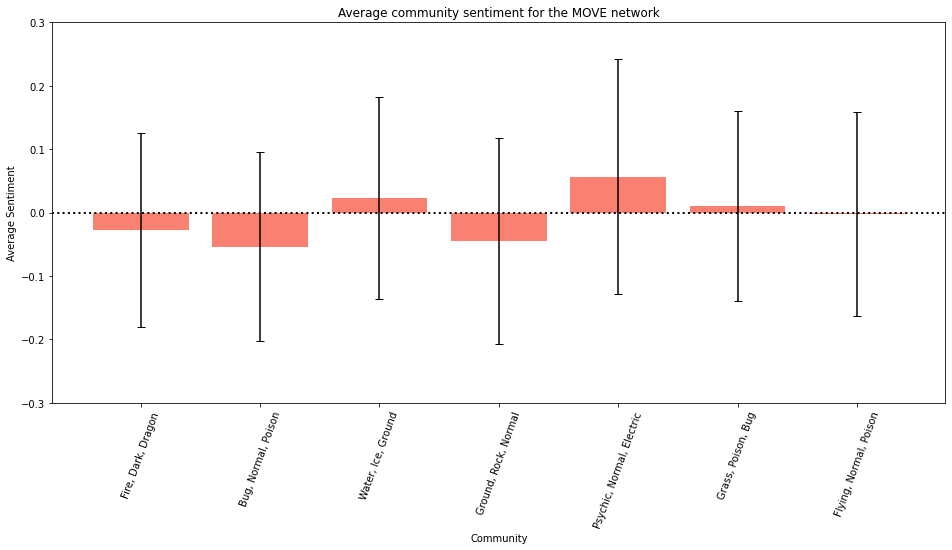

In [118]:
fig, ax = plt.subplots(1,1,figsize=(16,7))

ax.bar(comm_sents.keys(), comm_sents.values(), yerr=comm_stds.values(), color='#FA8072', capsize=4)
ax.set_title('Average community sentiment for the MOVE network')
ax.set_xlabel('Community')
ax.set_ylabel('Average Sentiment')
ax.set_ylim([-.3, .3])
plt.xticks(rotation='70')
plt.axhline(y=0, color='black', linestyle='dotted', linewidth=2)
plt.show()

The average sentiments of each of the communities in the **MOVE** network are, just like in the **TYPE** network, very close to each other with a very large standard deviation. While it seems that there is a lot of overlap between the communities of the two networks, the sentiment analysis does not tell us a lot about these communities except that the Pokémon of a given **TYPE** or with a given **MOVE**set can have a wide variety of sentiments.

# Discussion

## What went well

I think that the extraction of the data and the subsequent creation of graphs went very well. Although there were a few hiccups, such as needing to use a second wiki to get the **MOVE**s, I ended up with some very useful pages to download. I also think the **TYPE** graph looks very nice even before using the Force Atlas 2 algorithm.

Analyzing the created networks and looking at their degree distributions was luckily very easy to understand because of the way the networks were created and I am very pleased with the decision to connect the nodes in the networks in the way that I did. I think it makes a lot of sense for this dataset, even though it is very different from the way we did it in the assignments.

The community analysis went very well. The networks naturally form easily understandable communities because of the way the networks were created. I am especially proud of the stacked bar plots with the **TYPE** makeup of each of the communities. They gave a lot of insight into the data and how the communities were partitioned in both networks. It was also very interesting to see the overlap between the communities of the two networks.


## Improvements

When it comes to the text and language processing it was a bit more difficult. The wordclouds did not turn out as well as I had hoped. There were a lot of redundant words which either appeared in every wordcloud or gave no real description of any characteristic for the Pokémon. I believe this is due to two things in particular. The first thing is, that I could not get TF-IDF to work properly for the wordclouds, so they are not as accurate as they should be. The other thing is that the descriptions on the Pokémon pages themselves were widely inconsistent. Many Pokémon did not have the same sections, which made it harder to properly extract the descriptions of each of them.

While the way that the networks were created and nodes connected was an overall plus, it also meant that the average degree of a node was ridiculously high, which made some of the visualizations very cluttered.

I would have liked to have done more analysis of the different generations of Pokémon, but it did not make sense to do in this project. I only included the first three generations here, since those are the ones I am familiar with and including more would be very difficult to visualize because of the high average degree of nodes, which would undoubtedly become even higher. 

An idea I had at the beginning to remedy this problem was to make a single node for each **TYPE** and then connect all Pokémon of that **TYPE** to that node. This would cause less of a strain in terms of number of edges, but I ultimately decided against this, since it would make some of the analysis parts a bit messier.

It would also have been nice to do sentiment analysis based on **TYPE** instead of community. I think that would have made a bit more sense, because even though the communities were based on **TYPE**, the sentiment between multiple **TYPE**s in any community could possible vary widely.

# References

Various contributors. (Last edited: 2022, June 1 by Jessie&James 1) *List of Pokémon.* Pokemon Wiki. [[1]](https://pokemon.fandom.com/wiki/List_of_Pok%C3%A9mon)

Various contributors. (Last edited: 2022, August 21 by ArcToraphim) *List of moves.* Bulbapedia: The community-driven Pokémon encyclopedia. [[2]](https://bulbapedia.bulbagarden.net/wiki/List_of_moves)

Various contributors. (Last edited: 2022, June 27 by Wolfram77) *Louvain method.* Wikipedia. [[3]](https://en.wikipedia.org/wiki/Louvain_method)

Rita, L. (2020, April 9) *Louvain Algorithm: An algorithm for community finding.* Towards Data Science. [[4]](https://towardsdatascience.com/louvain-algorithm-93fde589f58c)

Various contributors. (Last edited: 2022 April 1 by cjhutto) *VADER-Sentiment-Analysis.* Github. [[5]](https://github.com/cjhutto/vaderSentiment)